In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random


import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

%load_ext autoreload
%autoreload 2

def make_clickable(val):
    return f'<a href="{val}">link</a>'

In [2]:
import sys

sys.path.append('..')
from util import load_sample,load_acertos,item_info_inep,item_stats,item_url,scalecalparams

In [3]:
sns.set_theme(
    context='notebook',
    style='darkgrid',
    palette='deep',
    font='sans-serif',
    font_scale=1.3,
    color_codes=True,
    rc=None,
)
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
# Uma função que retorna estatísticas da Teorica Clássica de Testes dos itens do ENEM.
# Rodar primeiro as células apropriados em 00-PrepareData para gerar os arquivos istats-xx-xx.csv

def istats(ano,area,sort_by='total.r',return_styled=False):
    istats = pd.read_csv(f'../data/istats-{ano}-{area}.csv')
    istats = istats.drop_duplicates('item')
    istats = istats.rename(columns={'CO_POSICAO':'pos','SG_AREA':'area','TX_GABARITO':'gab',
                                   'CO_HABILIDADE':'habilidade','IN_ITEM_ABAN':'aban',
                                   'TX_MOTIVO_ABAN':'motivo','NU_PARAM_A':'a','NU_PARAM_B':'b','NU_PARAM_C':'c',
                                   'TX_COR':'cor','CO_PROVA':'prova','TP_LINGUA':'ling',
                                   'IN_ITEM_ADAPTADO':'adaptado','TP_VERSAO_DIGITAL':'digital'})
    istats = istats.sort_values(sort_by)
    if return_styled:
        return istats.style.format({'url':make_clickable,
                                'mean':'{:.2f}','sd':'{:.2f}','total.r':'{:.3f}',
                               'habilidade':'{:.0f}'})
    return istats
# istats(2009,'MT')

In [5]:
# um dataframe com todos os itens do ENEM e seus parâmetros TRI dado pelo INEP
l = []
for ano in range(2009,2024):
    for area in ['CN','CH','MT']:
        slope,intercept = scalecalparams(area=area)
        df = istats(ano,area)
        df['a_enem'] = df['a']/slope
        df['b_enem'] = df['b']*slope + intercept
        l.append(df)
allitems = pd.concat(l)
allitems = allitems.set_index('item',verify_integrity=False)

# Os parâmetros TRI das questões do ENEM, segundo o INEP 
Os parâmetros das questões ("itens") do ENEM incluem sua "dificuldade" e "discriminação". Visualizamos abaixo a distribuição destes parâmetros para as questões do ENEM aplicados entre 2009 e 2023, para as três áreas Ciências da Natureza (CN), Ciências Humanas (CH) e Matemática (MT).

O parâmetro "dificuldade" está na escala ENEM. Um candidato com uma nota muito abaixo da dificuldade do item tem pouca chance de acertar. 

O parâmetro "discriminação" indica o poder de distinguir entre candidatos. Itens com um parâmetro > 2 são considerados bons itens.

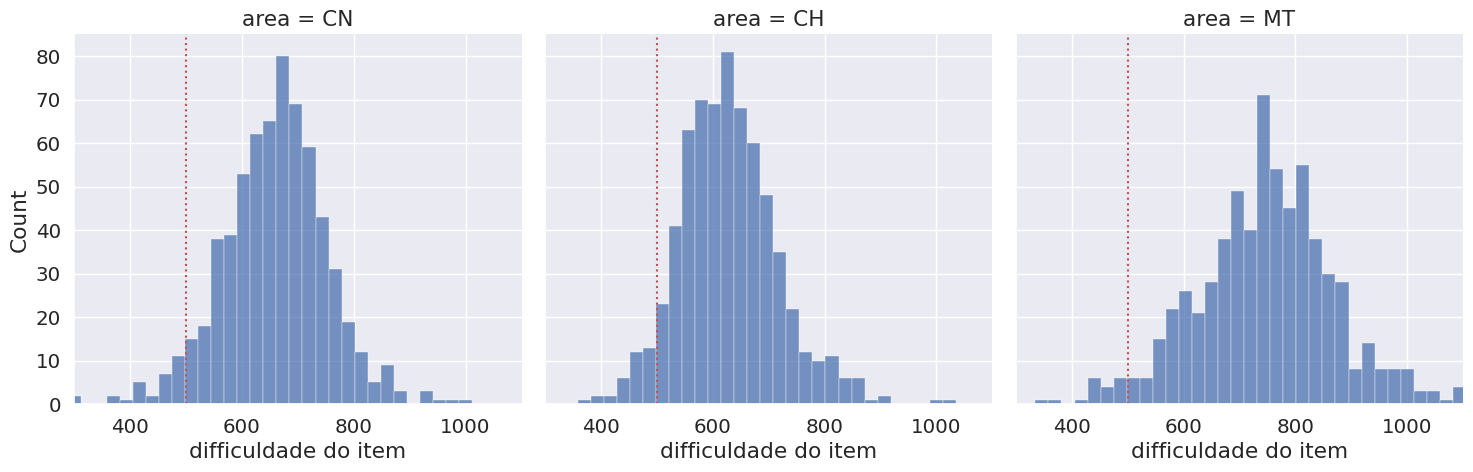

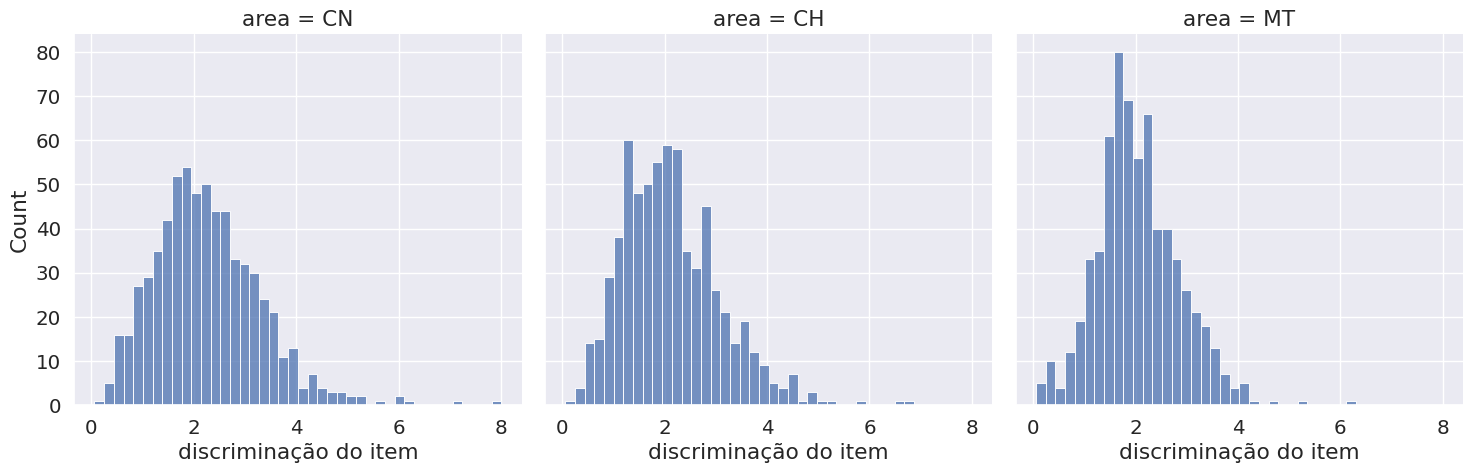

In [6]:
data = allitems.dropna(subset='b')
data = data.query('b < 60')
g = sns.displot(data,x='b_enem',col='area')
g.set(xlim=(300,1100))
g.set(xlabel='difficuldade do item')
for ax in g.axes.flat:
    ax.axvline(x=500, color='r', linestyle=':')
ga = sns.displot(data,x='a',col='area')
ga.set(xlabel='discriminação do item');

# Como o parâmetro dificuldade dos itens se compara com a a habilidade da população?
O fato que os itens do ENEM tem, na grande maioria dos casos, dificuldades acima de 500 na escala ENEM (a média da população de candidatos) significa que o exame não traz muita informação sobre estes candidatos. A dificuldade das questões do ENEM está muito  

In [7]:
def diffig(ano):
    pop = load_sample(ano,10000)
    itens = allitems.query("ano == @ano and aban == 0")
    areas = ['CH','CN','MT']
    fig,axs = plt.subplots(1,len(areas),sharex=True,sharey=True)
    for area,ax in zip(areas,axs):
        sns.histplot(itens.query("area == @area"),x='b_enem',stat='density',label='itens',ax=ax)
        sns.kdeplot(pop,x=f'NU_NOTA_{area}',color='indianred',label='candidatos',ax=ax)
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_yticklabels("")
        ax.set_yticks([])
        ax.set_title(f"área = {area}")
    ax.set_xlim(300,1000)
    fig.supxlabel("Nota e dificuldade (escala ENEM)")
    fig.set_figwidth(16)
    plt.subplots_adjust(bottom=0.15)
    #plt.tight_layout()
    plt.figlegend(labels=['candidatos','itens'],loc=(0.8,0.8),facecolor='w');

interact(diffig,ano=range(2009,2024));

interactive(children=(Dropdown(description='ano', options=(2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 201…

# Como os parâmetros de discriminição e dificuldade dependem do ano?
As tendências acima, que os itens de CN, CH e em particular MT são muito difíceis comparado com a população de candidatos, é estável ao longo dos anos.

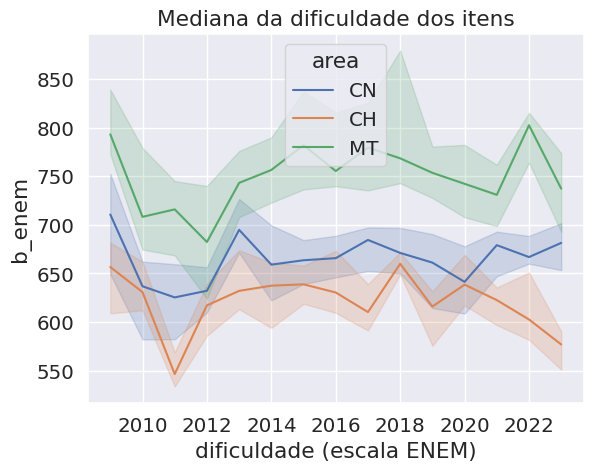

In [8]:
data = allitems.dropna(subset='b')
data = data.query('b < 60')
ax = sns.lineplot(data,x='ano',y='b_enem',hue='area',estimator='median')
ax.set_xlabel("dificuldade (escala ENEM)")
ax.set_title("Mediana da dificuldade dos itens");

# Correlação entre os parâmetros a e b
A correlação ponto - biserial do TCT (`total.r'` nos gráficos abaixo) é um indicador da confiabilidade ou consistência do item: é a correlação entre os acertos deste item e a pontuação total na prova. Poderíamos pensar que esta correlação poderia ser associado com o parâmetro `a` = discriminação do TRI. Mas como vemos abaixo, não é isso que acontece. Ao vez disso, é a *dificuldade* `b` que é correlacionada: quanto mais difícil um item, menos consistente ou confiável o item é.

In [9]:
#Análise temporal da correlação entre os parâmetros a e b
print(len(allitems))
data = allitems.dropna(subset=['a'])
print(len(data))
data = data.query('b < 10')
print(len(data))

2025
1988
1982


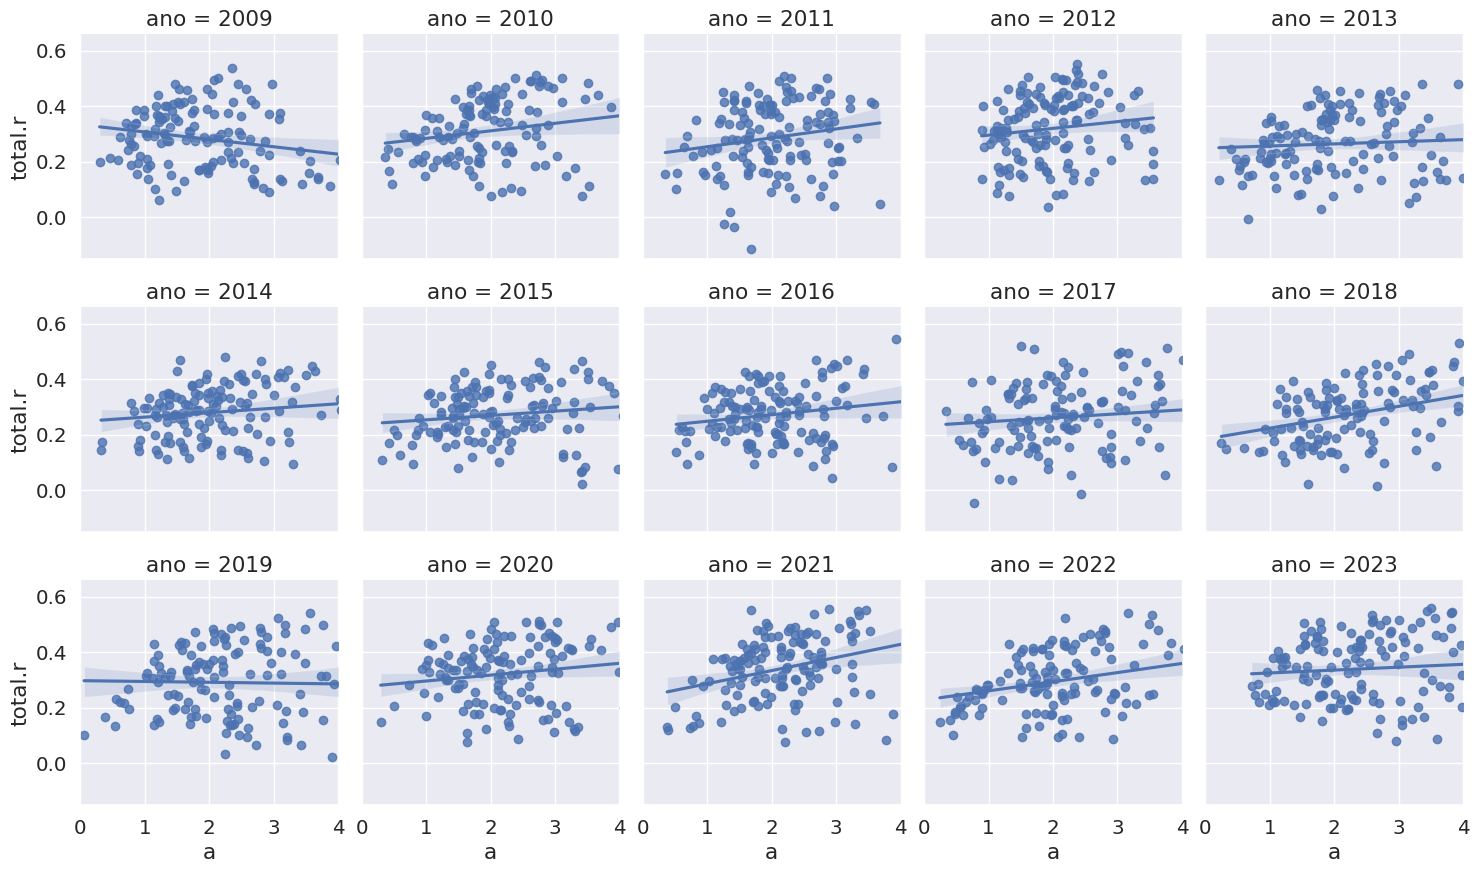

In [10]:
plot = sns.FacetGrid(data, col="ano", #hue='area',
                     col_wrap=5, legend_out=True)
plot.map(sns.regplot,"a","total.r",scatter=True)
plot.set(xlim=(0,4))

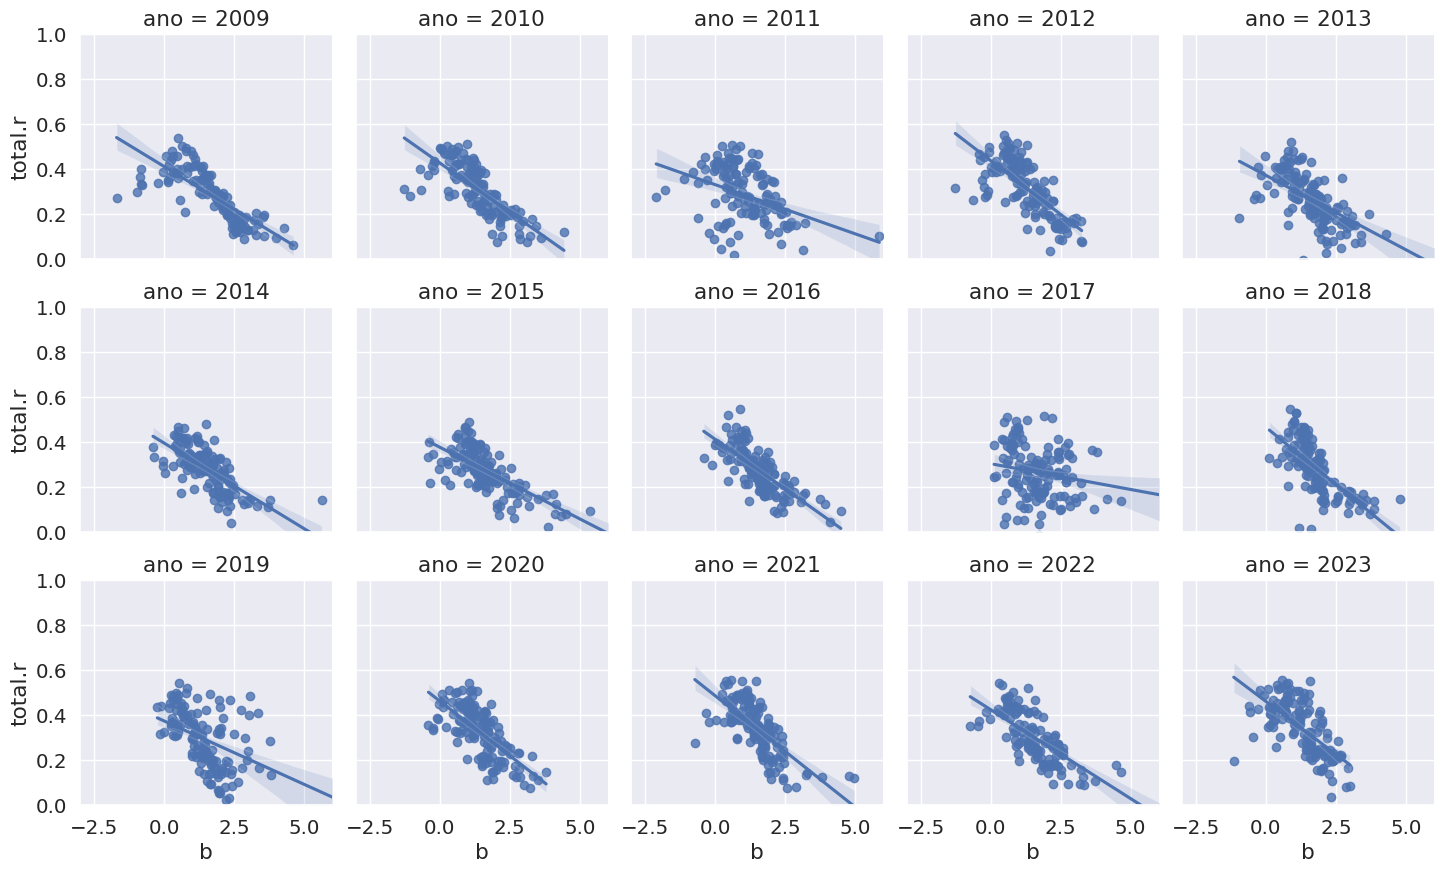

In [11]:
plot = sns.FacetGrid(data, col="ano", col_wrap=5)
plot.map(sns.regplot,"b","total.r",scatter=True)
plot.set(xlim=(-3,6))
plot.set(ylim=(0,1))

Pelo menos a dificuldade `b` e o índice de dificuldade do TCT ("mean", ou a taxa de acertos desta questão) são correlacionados?!

Sim, isso sim.

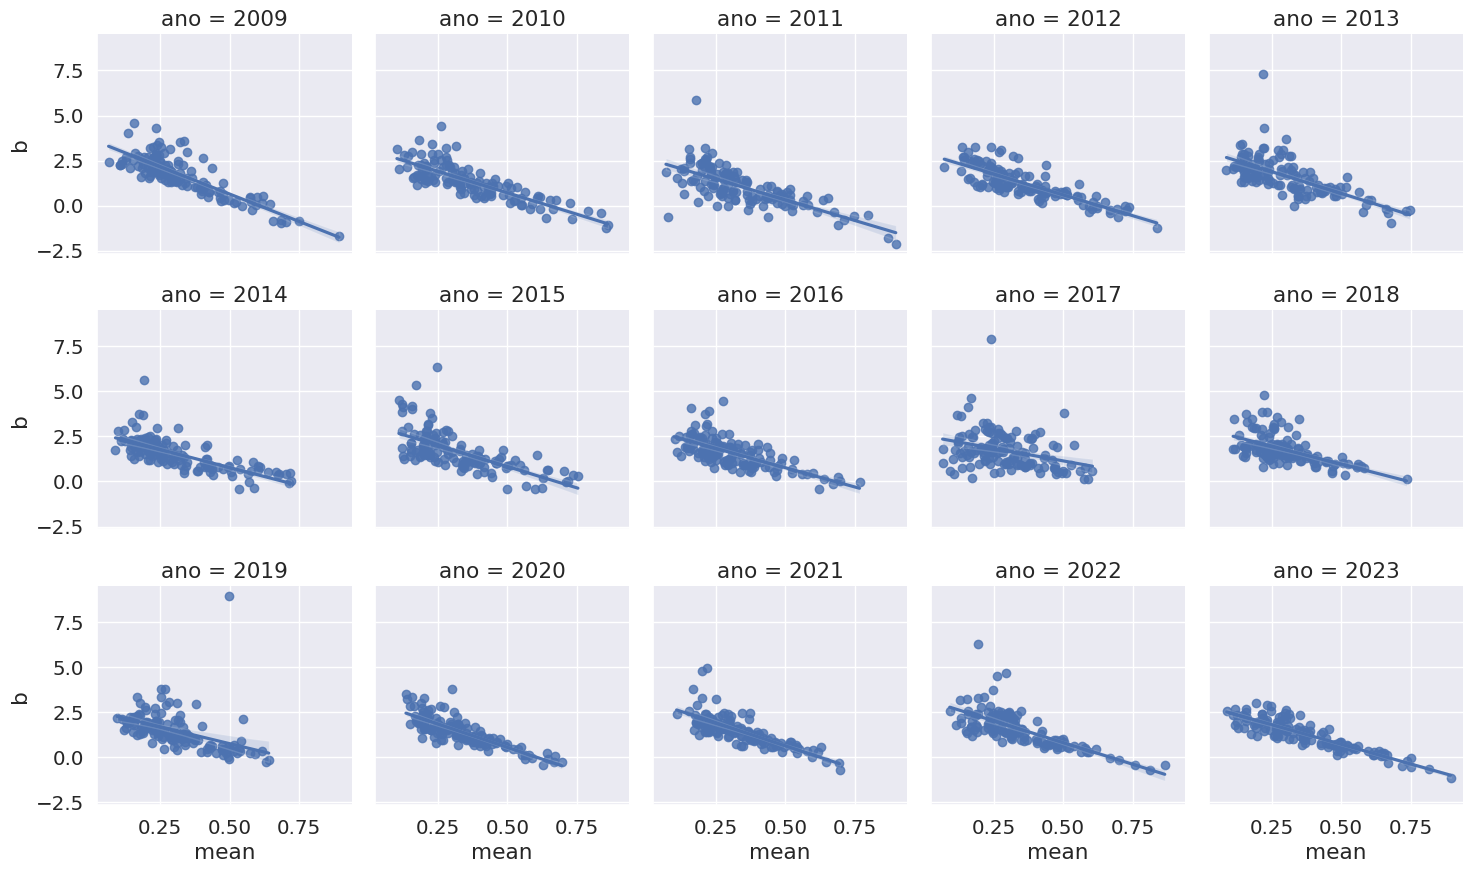

In [12]:
plot = sns.FacetGrid(data, col="ano", col_wrap=5)
plot.map(sns.regplot, "mean", "b",scatter=True)